<a href="https://colab.research.google.com/github/dhruszecki/cdatos-st-tp/blob/main/turing_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('df_diccs_parametros_uniqW.csv')

In [ ]:
df = df[['id', 'dialog_id', 'uniqWeight', 'sender_class']]

In [ ]:
df.head()

,id,dialog_id,uniqWeight,sender_class
0,0,0xab38710,0.179995,Bot
1,1,0xab38710,0.183899,Human
2,2,0xab38710,0.107382,Bot
3,3,0xab38710,0.109968,Human
4,4,0xab38710,0.152454,Bot


In [ ]:
len(df)

47234

In [ ]:
series = [serie for _, serie in df.groupby(by=['dialog_id', 'sender_class'])]

In [ ]:
len(series)

5551

Nos quedamos con series de al menos 4 interacciones y maximo 30
y que no tengan valores de uniqWeight por fuera del rango (0,1)

In [ ]:
min_lenght = 4
max_lenght = 30

series_to_drop = []

for i in range(len(series)):
  if len(series[i]) < min_lenght or len(series[i]) > max_lenght:
    series_to_drop.append(i)
  if (series[i]['uniqWeight'] > 1).any() or (series[i]['uniqWeight'] < 0).any():
    series_to_drop.append(i)
for ele in sorted(series_to_drop, reverse = True):
    del series[ele]

In [ ]:
len(series)

2709

In [ ]:
longitudes = []
for serie in series:
  longitudes.append(len(serie))

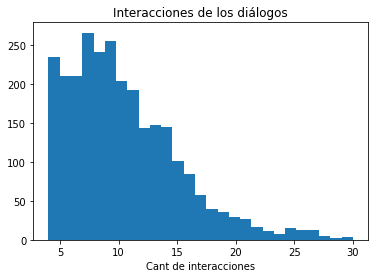

In [ ]:
plt.hist(longitudes, bins=27)
plt.xlabel('Cant de interacciones')
plt.title('Interacciones de los diálogos')
plt.show()

In [ ]:
series[0]

'Bot'

Atencion: la clase "bot" es la clase 1. 
La clase 'human' es la clase 0.

In [ ]:
X = []
y = []
for i, serie in enumerate(series):
  X.append(serie['uniqWeight'])
  y.append(int(serie['sender_class'].iloc[0] == 'Bot'))

y = np.array(y)

In [ ]:
random_state = 1

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.2, random_state=random_state)
print('Train X: '+str(len(X_train)))
print('Train y: '+str(len(y_train)))
print('Dev X: '+str(len(X_dev)))
print('Dev y: '+str(len(y_dev)))
print('Test X: '+str(len(X_test)))
print('Test y: '+str(len(y_test)))

Train X: 1733
Train y: 1733
Dev X: 434
Dev y: 434
Test X: 542
Test y: 542


Vamos a usar DTW (Dynamic Time Warping) para comparar las series temporales
Que es esto?: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

In [ ]:
###  OJO!! Cada instancia de test tarda unos 5 segundos en predecir. 

cuantas_instancias_de_test_corremos = len(X_test)


cuantas_instancias_de_test_corremos = min(cuantas_instancias_de_test_corremos, len(X_test))
predicciones = np.zeros(cuantas_instancias_de_test_corremos)

for i in range(len(predicciones)):

  distancia_acumualda = np.zeros(2)

  for j in range(len(X_train)):
    distancia_acumualda[y_train[j]] += fastdtw(X_train[j], X_test[i], dist=euclidean)[0]

  distancia_acumualda[0] /= len(y_train[y_train==0])
  distancia_acumualda[1] /= len(y_train[y_train==1])

  if distancia_acumualda[1] < distancia_acumualda[0]:
    predicciones[i] = 1


Comparemos el ground truth con lo predicho. En el caso de muestras generadas al azar, deberia dar cerca de 0.5 (si corremos unos cuantos ejemplos de test)

In [ ]:
predicciones_correctas = np.sum(y_test[:cuantas_instancias_de_test_corremos] == predicciones)

predicciones_correctas_pretty_print = round(100 * predicciones_correctas / cuantas_instancias_de_test_corremos, 3)
print("Predicciones correctas: {} %".format(str(predicciones_correctas_pretty_print)))

Predicciones correctas: 59.041 %


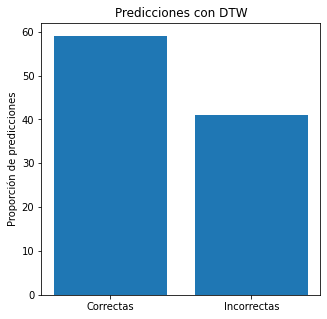

In [ ]:
 
fig = plt.figure(figsize = (5, 5))
 
# creating the bar plot
#plt.bar(['Correctas', 'Incorrectas'], x=[0,1],[predicciones_correctas_pretty_print, 100-predicciones_correctas_pretty_print], width = 0.5)
 
plt.bar([0,1], [predicciones_correctas_pretty_print, 100-predicciones_correctas_pretty_print])
plt.xticks([0,1], ['Correctas', 'Incorrectas'])
plt.ylabel("Proporción de predicciones")
plt.title("Predicciones con DTW")
plt.show()